In [1]:
import os, sys, pathlib
base_path = '/home/marcel/repo/github_mzoll'
projects = ['sklearnext']

for p in projects:
    sys.path.insert(0, os.path.join(base_path, p))

In [2]:
'''
simplistic example showing how to use the modules contained in sklearnext
'''

#import sys, os, pathlib
#sys.path.insert(0, str(pathlib.Path(os.getcwd()).parents[1] / 'python'))

#some basic imports
import sys, os, copy
import numpy as np
import datetime as dt
import pandas as pd

#set a seed for the random number generator
np.random.seed( 1000 )

In [3]:
#=========================================================================
# construct a dataset with some observations and all kind of mixed lables
#=========================================================================

#--- define the sample size
nObs = 10000

#--- create a observation matrix
idx = np.array(list(range(nObs))) + 1000
c0 = np.array(np.random.choice(['A','B'], size=int(nObs*0.8)).tolist() + ['A']*int(nObs*0.2) )

c1_h = np.random.choice([12,13,14], size=nObs)
c1_d = np.random.choice([0,1], size=nObs)
c1_s = np.random.randint(60, size=nObs)

c1 = []
for i in range(nObs):
    c1.append( dt.datetime(2017,1,1,0,0,0) + dt.timedelta(days=int(c1_d[i]), hours=int(c1_h[i]), minutes=int(c1_s[i])) )

c2 = np.random.choice(['a','b','c'], size=nObs)
c3 = np.round(np.random.rand(nObs), 2)

X = pd.DataFrame({'Device': c0,
             'Time': c1,
             'Label':c2,
             'Cont':c3}, index = idx)

print(X.shape, X.columns)

#--- create a results vector
class xthelper():
    j = 0
    def __int__(self):
        pass
    def __call__(self, row):
        dev_dict = {'A':0.3, 'B':0.8}
        label_dict = {'a':0.8, 'b':0.6, 'c':0.7}
        prob =  ( 0.5 + 0.1*c1_d[self.j] - (c1_h[self.j]-12)*0.5 ) * label_dict[row['Label']] + (row['Cont']-0.5)/4
        prob = max(min(1.,prob), 0.)

        self.j+=1
        if row['Device'] == 'A':
            return int(prob>0.3)
        else:
            return int(prob>0.5)
    
y= X.apply(xthelper(), axis=1)

print(y.shape, "coverage %f" % (np.sum(y)/y.shape[0]))

#split up dataset into train and (held out)test sample
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(10000, 4) Index(['Device', 'Time', 'Label', 'Cont'], dtype='object')
(10000,) coverage 0.178800
(8000, 4) (8000,) (2000, 4) (2000,)


In [4]:
#======================
# PIPELINE ASSEMBLY
#======================
from sklearnext.assembly import *
from sklearnext.sklearn.estimators.gbdtree_learner import *
from sklearnext.sklearn.estimators.oneprob_classifier import *
from sklearnext.estimators.wrappers import *
from sklearnext.transformers import *

#assemble the pipeline by bits an pieces

#OneHot/Label encoding for feature 'Label'
tf0 = TransformerPipe([
        ('pagehistExtr', ColumnsSelect(['Label'])),
        ('labelEnc', OneHotTransformer())
    ])

#Extraction of Hour and Day-of-Month fromfeature  'Time'
tf1 = TransformerPipe([
        ('starttimeExtr', ColumnsSelect('Time')),
        ('hwdmyExtr', HourWeekdayDayMonthYearTransformer()),
        ('hwdselect', ColumnsSelect(['Time_hour', 'Time_day']))
    ])

#assemble a set of to use features
fu = FeatureUnion([
        ('tf0', tf0),
        ('tf1', tf1),
        ('tf2', ColumnsSelect('Cont')) # feature 'Cont' could have been wrapped into its own pipeline,
                                       # but no need to convolute as already in correct format
    ], n_jobs= 1)

#define a Classifier estimator; here one that is smarter as the average by growing additional trees
skl_c0 = GrowingGBClassifier(ntrees_start = 100,
            ntress_increment = 10,
            est_params = {'max_depth': 3,
                          'max_features': None}, #auto
            scoring = 'log_loss', #binary_roc_auc
            min_score_improvement = 1e-5,
            nrounds_noimp = 2,
            nrounds_stop = sys.maxsize,
            cv_test_frac = 0.2, 
            cv_n_splits = 3)
                      
#as we are interested in the probabilities rather than the absolute binary classification use this shim
skl_cc0 = OneProbClassifierWrapper(skl_c0, predictClass=1)

# as OneProbClassifier (and GrowingGBClassifier) are using the sklearn interface, make them pandas compatible
#cc0 = SklearnerWrapper(skl_cc0)
cc0 = SKLEstimatorExtender(skl_cc0)

#this is a complete pipeline, which uses all features except 'Device'
pred_pipe = Pipeline([
        ("fu",fu),
        ("cc0", cc0)
    ])

#make a categorical fork for the feature Device, which has two levels
cf = CategoryFork(pred_pipe,
                  'Device',
                  [('A'),('B')],
                  n_jobs=1 )

#define this by an alias
main_pipe = cf

In [5]:
logging.basicConfig(level=logging.INFO)

In [6]:
#=============================
# Train, Verify and Quantisize the model
#=============================

#--- train the pipeline
main_pipe.fit(X_train, y_train)

INFO:GrowingTreeEstimator:resetting estimator to null-state
INFO:GrowingTreeEstimator:With 210 estimators:: TrainScore(cv-test): -0.002968 , TrainScore(all): -0.000700
INFO:GrowingTreeEstimator:resetting estimator to null-state
INFO:GrowingTreeEstimator:With 100 estimators:: TrainScore(cv-test): -0.008600 , TrainScore(all): -0.001316


In [10]:
y_test_pred = main_pipe.predict(X_test)
y_train_pred = main_pipe.predict(X_train)

In [11]:
#--- verify the model
from sklearnext.metric.check import *
ClassifierOvertrainCheck(y_test, y_test_pred, y_train, y_train_pred)

Support :: train 2000  test 8000
Coverage :: train 0.185500  test 0.177125
RocAuc score :: train: 0.999960  test: 1.000000  diff: -3.971150e-05


/home/marcel/.local/lib/python3.6/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


ValueError: x is neither increasing nor decreasing : [0.99731183 0.99730458 0.9972973  0.99728997 0.99726776 0.99726027
 0.99725275 0.99724518 0.99723757 0.99717514 0.99716714 0.99715909
 0.997151   0.99714286 0.99713467 0.99712644 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.        ].

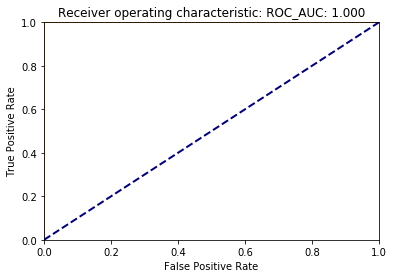

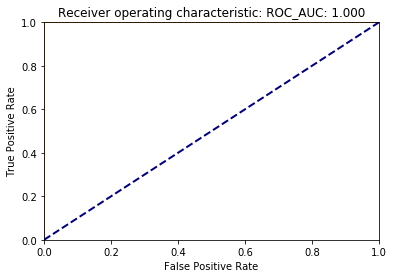

In [12]:
from sklearnext.metric.curves import plot_BinaryRocCurve
plot_BinaryRocCurve(y_test, y_test_pred)

In [13]:
#--- have a look at the most important features for each pipeline
fi_deep = cf.get_feature_importances_deep()
print(fi_deep)

fi = cf.get_feature_importances()
print(fi)

[('tf0__Label_b', [0.04166873597230181, 0.135234633063582]), ('tf2__Cont', [0.13859633158440202, 0.4324543123087198]), ('tf1__Time_hour', [0.7646683276216771, 0.20322760207354187]), ('tf0__Label_a', [0.025364352509549395, 0.12301334508573969]), ('tf1__Time_day', [0.02812154170855526, 0.10370006955608335]), ('tf0__Label_c', [0.0015807106035144092, 0.0023700379123334408])]
[('tf0__Label_b', 0.07879100564326721), ('tf2__Cont', 0.2551844854367751), ('tf1__Time_hour', 0.5419167197604544), ('tf0__Label_a', 0.06410659031415289), ('tf1__Time_day', 0.05810732263206203), ('tf0__Label_c', 0.00189387621328836)]


/home/marcel/.conda/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


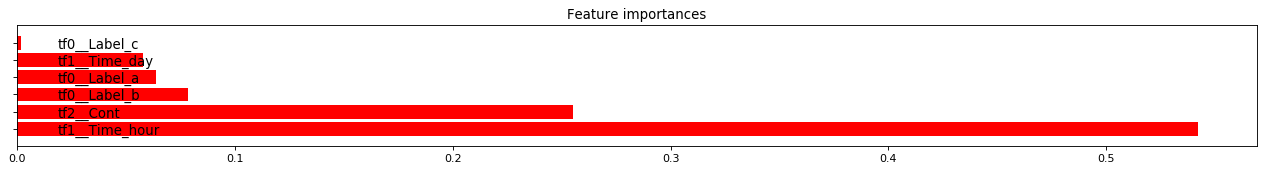

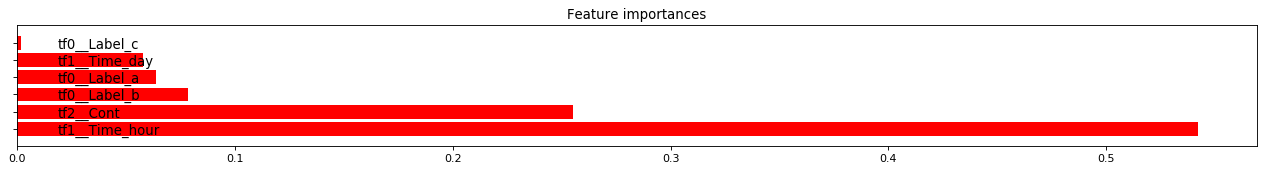

In [14]:
#--- plot the feature importances
from sklearnext.visualization.viz import *
plot_FeatureImportances(main_pipe)

A 0.60325
B 0.39675


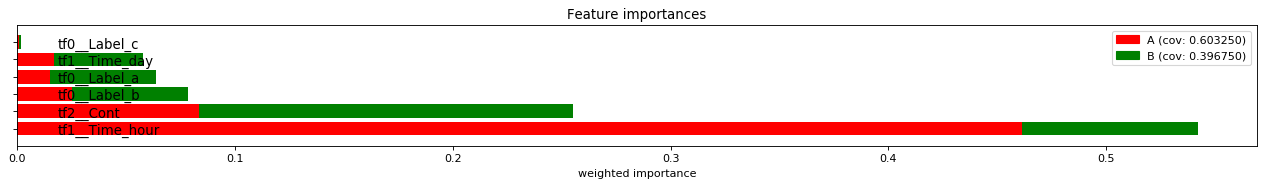

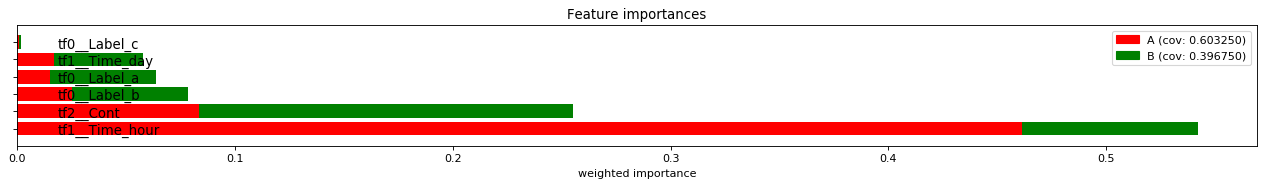

In [15]:
from sklearnext.assembly.viz.category_fork import *
plot_CategoryFork_FeatureImportances(main_pipe, coverage_weighted=True)

A 0.60325
B 0.39675


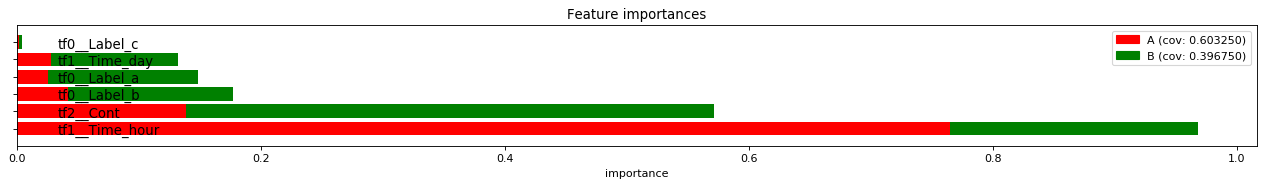

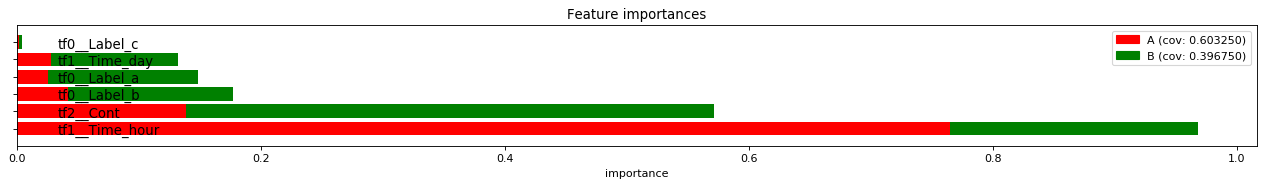

In [16]:
plot_CategoryFork_FeatureImportances(main_pipe, coverage_weighted=False)

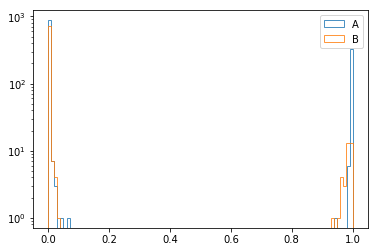

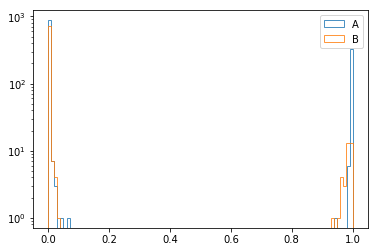

In [17]:
plot_CategoryFork_prediction(main_pipe, X_test)

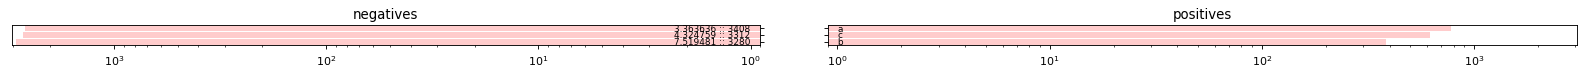

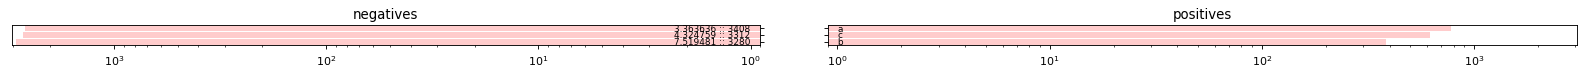

In [18]:
plot_BinaryOutcomeDist(X, y, 'Label', sys.maxsize)